In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from ttvfast import ttvfast
from ttvfast.models import Planet 
from astropy.constants import M_sun, M_earth
import numpy as np
import astropy.units as u

midtransit_f = 2455422.710
midtransit_e = 2454983.404
period_f_init = 267.291
period_e_init = 122.3874

# phase = 360 * (midtransit_f - midtransit_e)/period_e % 1

mass_e_init = 4.45356410231 * float(M_earth/M_sun) # Forecaster + Gaia (Berger 2018, Chen+ 2017)
mass_f_init = 3.26277846782 * float(M_earth/M_sun) # Forecaster + Gaia (Berger 2018, Chen+ 2017)

em, eu, el = 4.45356410231 * float(M_earth/M_sun), 3.18331500837 * float(M_earth/M_sun), 1.68965648037 * float(M_earth/M_sun)
fm, fu, fl = 3.26277846782 * float(M_earth/M_sun), 2.10481702794 * float(M_earth/M_sun), 1.15211292891 * float(M_earth/M_sun)

mass_e_init_err = np.max([eu, el])
mass_f_init_err = np.max([fu, fl])

In [2]:

observed_timing = np.loadtxt("../libra/data/ttvs/timing_k62_Kep_HST.txt", delimiter=',')
timing_e = observed_timing[observed_timing[:, 0] == 1][:, -3:]
timing_f = observed_timing[observed_timing[:, 0] == 2][:, -3:]

timing_e[:, 1] += 2450000
timing_f[:, 1] += 2450000

all_e = np.load('all_transits_e.npy')
all_err_e = (25*u.s).to(u.day).value * np.ones_like(all_e)
all_f = np.load('all_transits_f.npy')
all_err_f = (41*u.s).to(u.day).value * np.ones_like(all_f)

all_epoch_e = np.round((all_e - timing_e[:, 1].min()) / period_e_init)
all_epoch_f = np.round((all_f - timing_f[:, 1].min()) / period_f_init) #+ 1

timing_e = np.vstack([timing_e, np.array([all_epoch_e, all_e, all_err_e]).T])
timing_f = np.vstack([timing_f, np.array([all_epoch_f, all_f, all_err_f]).T])

epochs_e, times_e, errs_e = timing_e.T
epochs_f, times_f, errs_f = timing_f.T

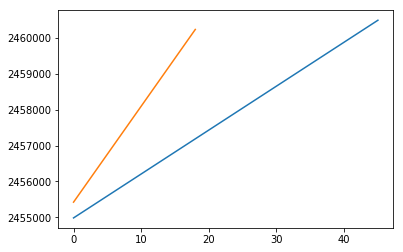

In [3]:
plt.plot(epochs_e, times_e)
plt.plot(epochs_f, times_f)

Text(0,0.5,'O-C [min]')

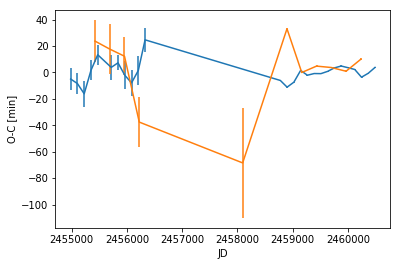

In [4]:
linear_ephem_e = np.polyval(np.polyfit(epochs_e, times_e, 1), epochs_e)
linear_ephem_f = np.polyval(np.polyfit(epochs_f, times_f, 1), epochs_f)
plt.errorbar(times_e, 24*60*(times_e - linear_ephem_e), 24*60*errs_e)
plt.errorbar(times_f, 24*60*(times_f - linear_ephem_f), 24*60*errs_f)
plt.xlabel('JD')
plt.ylabel('O-C [min]')

Build a sample model to check that residuals are small: 

In [5]:
360 *( ((times_e.min() - times_f.min())/period_f_init) % 1)

128.33075376874552

In [6]:
phase = 360 * (((times_e.min() - times_f.min())/period_f_init) % 1 )
print(phase)

e = Planet(mass=mass_e_init, period=period_e_init, eccentricity=0, inclination=89.98, 
           longnode=90, argument=90, mean_anomaly=0)
f = Planet(mass=mass_f_init, period=period_f_init, eccentricity=0, inclination=89.90, 
           longnode=90, argument=90, mean_anomaly=phase)
result = ttvfast(planets=[e, f], stellar_mass=0.69, time=times_e.min(), dt=period_e_init/50, total=times_e.min()+6000)
planet_ind, epoch, times, rsky, vsky = [np.array(i) for i in result['positions']]
condition = (times != -2)
planet_ind, epoch, times, rsky, vsky = [i[condition] for i in [planet_ind, epoch, times, rsky, vsky]]

indices_e = (planet_ind == 0) & np.in1d(epoch, epochs_e)
indices_f = (planet_ind == 1) & np.in1d(epoch, epochs_f + 1)
epoch_e = epoch[indices_e]
epoch_f = epoch[indices_f]
model_times_e = times[indices_e]
model_times_f = times[indices_f]

# logchi2_e = -0.5 * np.sum( (model_times_e - times_e)**2 / errs_e**2 )
# logchi2_f = -0.5 * np.sum( (model_times_f - times_f)**2 / errs_f**2 )

model_times_e - times_e, model_times_f - times_f

128.330753769


(array([  3.35276127e-08,   6.31728303e-03,   1.39195984e-02,
          6.87640812e-03,   9.29938629e-04,   1.29993688e-02,
          1.20292637e-02,   1.89485396e-02,   2.31867135e-02,
          1.72095331e-02,   2.07092147e-03,   7.00560845e-02,
          7.38931973e-02,   7.15008858e-02,   6.60728621e-02,
          6.96659489e-02,   7.18965856e-02,   7.40035060e-02,
          7.79044549e-02,   7.84253897e-02,   8.20895522e-02,
          8.47554989e-02,   8.78945328e-02,   9.26698577e-02,
          9.09294500e-02,   8.81123827e-02]),
 array([-0.02956353, -0.04951757, -0.06775273, -0.0537453 , -0.19507851,
        -0.33573583, -0.33364209, -0.36073913, -0.38453105, -0.40697607,
        -0.43624815]))

Simulated times to fit: 

In [7]:
# np.random.seed(1234)

# time_err = (50 * u.s).to(u.day).value

# times_e = np.load('example_times_e.npy') 
# times_e += time_err * np.random.randn(len(times_e))
# times_f = np.load('example_times_f.npy')
# times_f += time_err * np.random.randn(len(times_f))

# plt.plot(times_e)
# plt.plot(times_f)

### TTVFast + emcee

fit the transit times using `TTVFast`

In [8]:
import emcee
from corner import corner

from astropy.constants import G, M_sun
M_starM_sun = 0.69
M_star = M_starM_sun * M_sun
a_e = ( ( (G * M_star)/(4 * np.pi**2) * (period_e_init*u.day)**2 )**(1/3) ).decompose()
a_f = ( ( (G * M_star)/(4 * np.pi**2) * (period_f_init*u.day)**2 )**(1/3) ).decompose()

def lnprob(p):
    mass_e, mass_f, period_e, period_f, lam_e, lam_f, ecc_e, ecc_f, w_e, w_f = p

    if (mass_e < 0 or mass_f < 0 or mass_e > 1e-3 or mass_f > 1e-3 or 
        ecc_e < 0 or ecc_e > 0.3 or ecc_f < 0 or ecc_f > 0.3):
        return -np.inf
    
    # Hill stability criterion from Gladman 1993 Eqn. 21
    gamma1 = np.sqrt(1 - ecc_e**2)
    gamma2 = np.sqrt(1 - ecc_f**2)
    mu1 = mass_e * M_starM_sun
    mu2 = mass_f * M_starM_sun
    alpha = mu1 + mu2
    Delta = (a_f - a_e)/a_e
    delta = np.sqrt(1 + Delta)
    
    if (alpha**-3 * (mu1 + mu2/delta**2)*(mu1*gamma1 + mu2*gamma2*delta)**2 <= 
        1 + 3**(4/3) * (mu1 * mu2) / alpha**(4/3)):
        return -np.inf
    
    # Run TTVFast
    e = Planet(mass=mass_e, period=period_e, eccentricity=ecc_e, inclination=89.98, 
               longnode=90, argument=w_e, mean_anomaly=lam_e)
    f = Planet(mass=mass_f, period=period_f, eccentricity=ecc_f, inclination=89.90, 
               longnode=90, argument=w_f, mean_anomaly=lam_f)
    result = ttvfast(planets=[e, f], stellar_mass=0.69, time=times_e.min()-0.01, 
                     dt=period_e/30, total=times_e.min()+6000)
    planet_ind, epoch, times, rsky, vsky = [np.array(i) for i in result['positions']]
    ignore_condition = (times != -2)
    planet_ind, epoch, times, rsky, vsky = [i[ignore_condition] for i in [planet_ind, epoch, times, rsky, vsky]]
    
    # Parse results for planets e and f
    indices_e = (planet_ind == 0) & np.in1d(epoch, epochs_e)
    indices_f = (planet_ind == 1) & np.in1d(epoch, epochs_f + 1)
    epoch_e = epoch[indices_e]
    epoch_f = epoch[indices_f]
    model_times_e = times[indices_e]
    model_times_f = times[indices_f]

    # Compute chi^2 for transit times of e and f
    logchi2_e = -0.5 * np.sum( (model_times_e - times_e)**2 / errs_e**2 )
    logchi2_f = -0.5 * np.sum( (model_times_f - times_f)**2 / errs_f**2 )

    # Add log prior for planet mass from Gaia + forecaster
    lnprior = (-0.5 * (mass_e - mass_e_init)**2 / mass_e_init_err**2
               -0.5 * (mass_f - mass_f_init)**2 / mass_f_init_err**2)
    return logchi2_e + logchi2_f + lnprior

ndim, nwalkers = 10, 100
init_masses = np.load('maxlnprob_ttv_params.npy') #np.array([mass_e_init, mass_f_init, period_e_init, period_f_init, 0, phase, 0.001, 0.001, 90, 90])
p0 = [init_masses + 1e-8 * np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads=8)
p1 = sampler.run_mcmc(p0, 5000)[0];
sampler.reset()
p2 = sampler.run_mcmc(p1, 10000)[0] # 15 min

In [9]:
# p3 = sampler.run_mcmc(p2[0], 50000); # >30 min

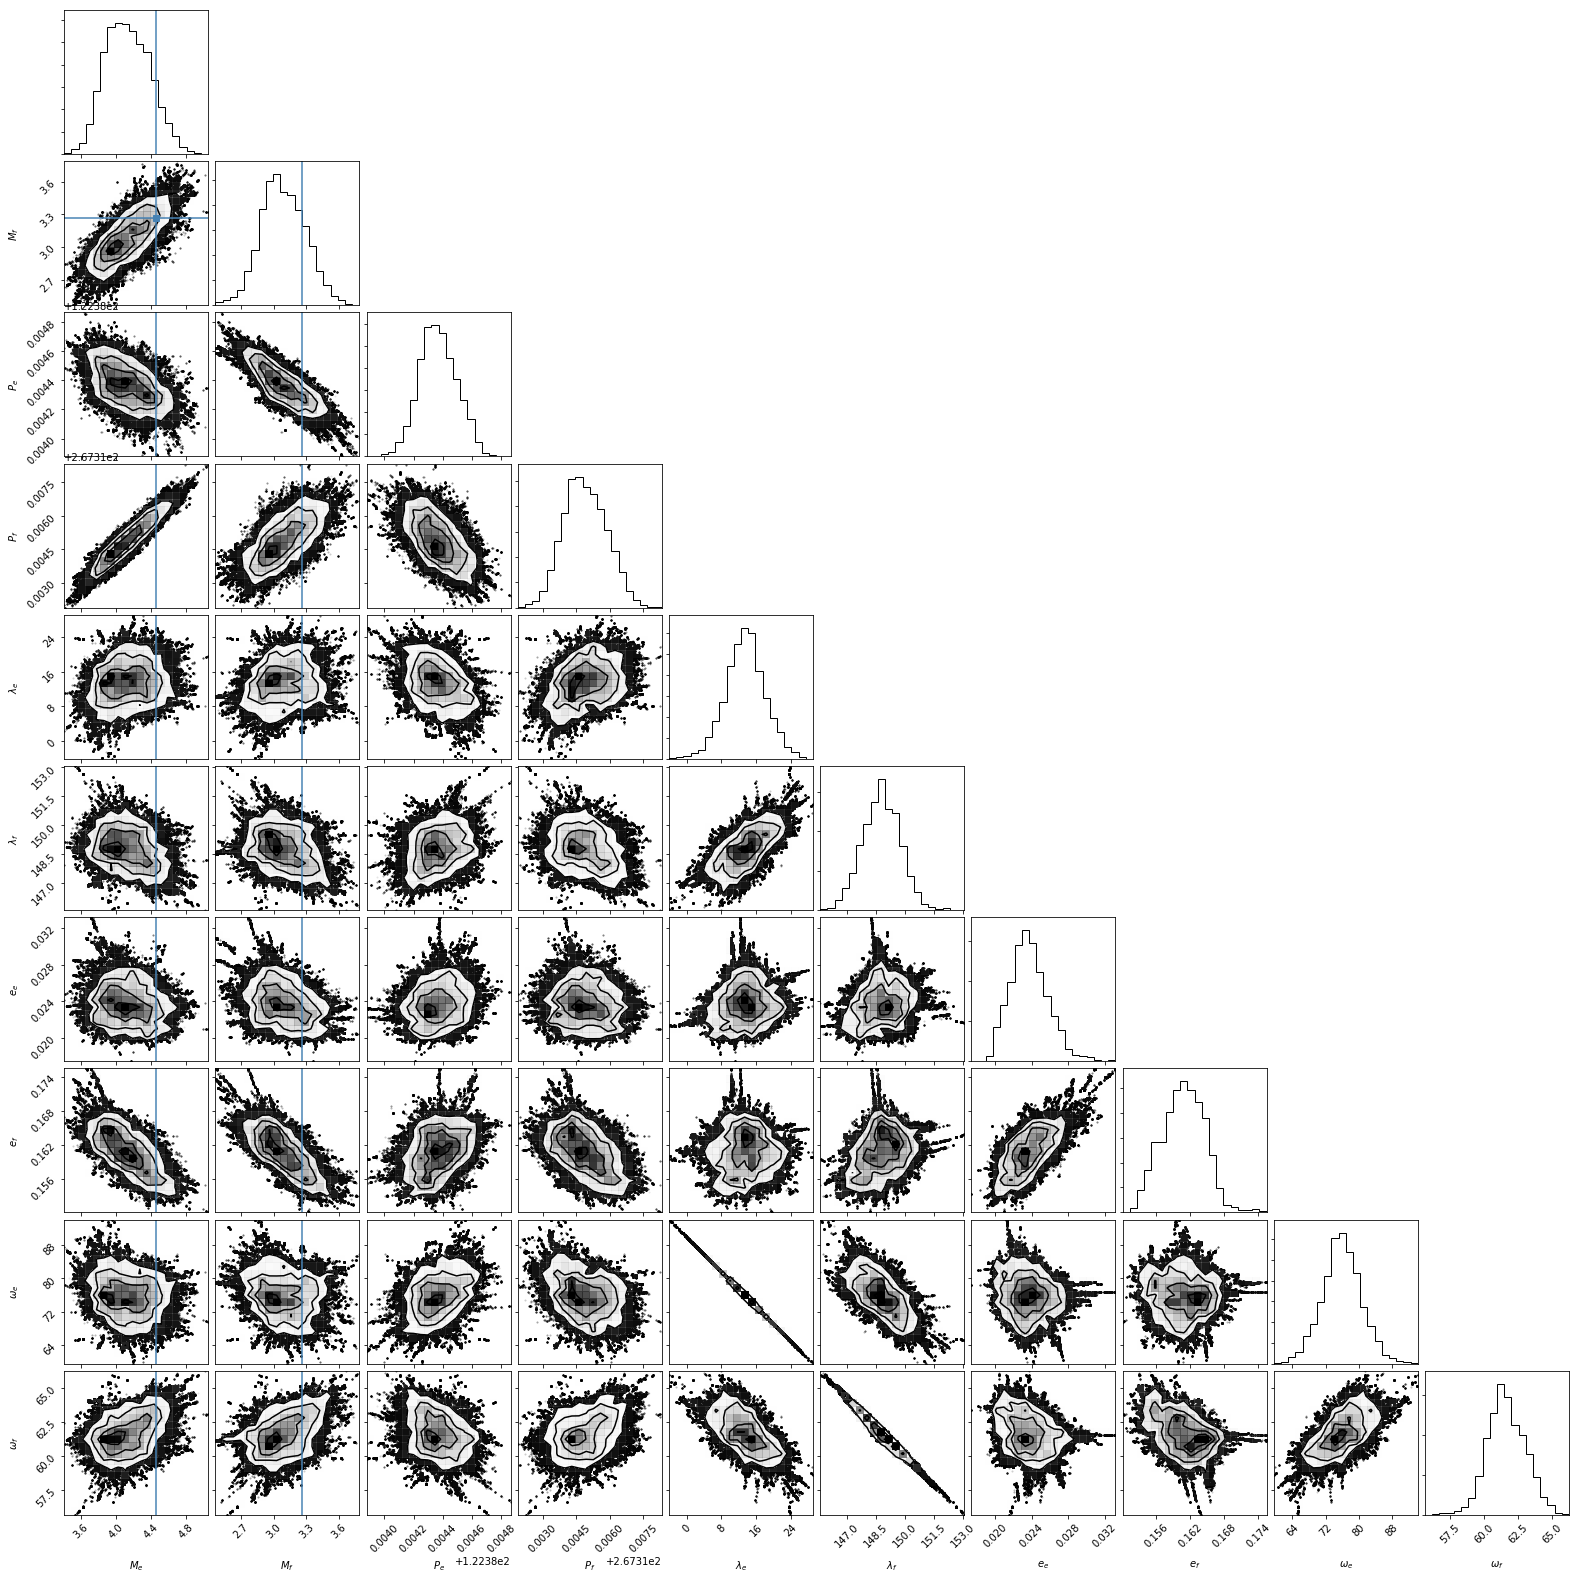

In [10]:
chains = np.copy(sampler.flatchain)
chains[:, :2] /= float(M_earth/M_sun)

corner(chains, 
       truths=[mass_e_init/float(M_earth/M_sun), mass_f_init/float(M_earth/M_sun), period_e_init, period_f_init, 
               None, None, None, None, None, None], 
       labels=['$M_e$', '$M_f$', "$P_e$", "$P_f$", '$\lambda_e$', "$\lambda_f$",
               "$e_e$", "$e_f$", "$\omega_e$", "$\omega_f$"]);
plt.savefig('ttv_kitchensink.png', bbox_inches='tight')

Below: Plot the posterior distributions for transit times (circles) over the observed transit times (squares). 

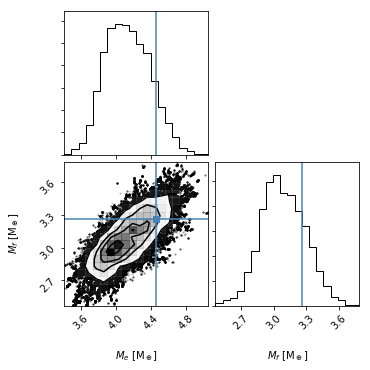

In [23]:
corner(chains[:, :2], labels="$M_e$ [M$_\oplus$],$M_f$ [M$_\oplus$]".split(','), truths=[mass_e_init / float(M_earth/M_sun), 
                                                                                         mass_f_init / float(M_earth/M_sun)]);
plt.savefig('masses_kitchen_sink.pdf', bbox_inches='tight')

In [12]:
np.save('median_ttv_params_kitchensink.npy', np.median(sampler.flatchain, axis=0))
np.save('maxlnprob_ttv_params_kitchensink.npy', sampler.flatchain[np.argmax(sampler.flatlnprobability), :])

In [13]:
np.save('samplerflatchain_kitchensink.npy', sampler.flatchain)
np.save('samplerflatlnrpob_kitchensink.npy', sampler.flatlnprobability)

In [21]:
polyparams_e

array([  1.22386235e+02,   2.45498341e+06])

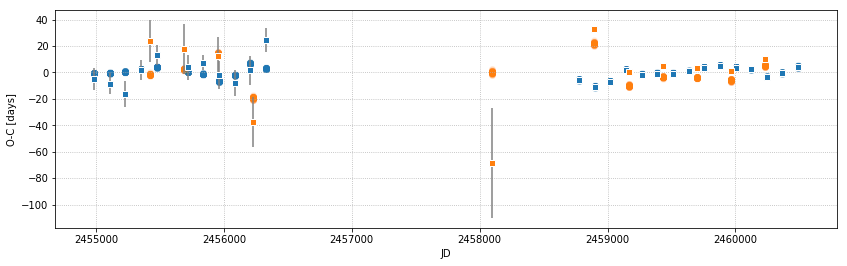

In [22]:
polyparams_e = np.polyfit(epochs_e, times_e, 1)
polyparams_f = np.polyfit(epochs_f, times_f, 1)

linear_ephem_e = np.polyval(polyparams_e, epochs_e)
linear_ephem_f = np.polyval(polyparams_f, epochs_f) 

plt.figure(figsize=(14, 4))
plt.errorbar(times_e, 24*60*(times_e - linear_ephem_e), 24*60*errs_e, fmt='s', mec='w', ecolor='gray', color='C0')
plt.errorbar(times_f, 24*60*(times_f - linear_ephem_f), 24*60*errs_f, fmt='s', mec='w', ecolor='gray', color='C1')

for i in range(100): 
    random_step = np.random.randint(sampler.flatchain.shape[0])

# for i in range(1):
#     random_step = np.argmax(sampler.flatlnprobability)
    mass_e, mass_f, period_e, period_f, lam_e, lam_f, ecc_e, ecc_f, w_e, w_f = sampler.flatchain[random_step, :]

    e = Planet(mass=mass_e, period=period_e, eccentricity=ecc_e, inclination=89.98, 
               longnode=90, argument=w_e, mean_anomaly=lam_e)
    f = Planet(mass=mass_f, period=period_f, eccentricity=ecc_f, inclination=89.90, 
               longnode=90, argument=w_f, mean_anomaly=lam_f)
    result = ttvfast(planets=[e, f], stellar_mass=0.69, time=times_e.min()-0.01, dt=period_e/50, total=times_e.min()+6000)
    planet_ind, epoch, times, rsky, vsky = [np.array(i) for i in result['positions']]
    ignore_condition = (times != -2)
    planet_ind, epoch, times, rsky, vsky = [i[ignore_condition] for i in [planet_ind, epoch, times, rsky, vsky]]
    
    indices_e = (planet_ind == 0) & np.in1d(epoch, epochs_e)
    indices_f = (planet_ind == 1) & np.in1d(epoch, epochs_f + 1)
    epoch_e = epoch[indices_e]
    epoch_f = epoch[indices_f]
    model_times_e = times[indices_e]
    model_times_f = times[indices_f]

    model_linear_ephem_e = np.polyval(np.polyfit(epoch_e, model_times_e, 1), epoch_e)
    model_linear_ephem_f = np.polyval(np.polyfit(epoch_f, model_times_f, 1), epoch_f) 

#     model_linear_ephem_e = np.polyval(polyparams_e, epoch_e)
#     model_linear_ephem_f = np.polyval(polyparams_f, epoch_f) 
    
    plt.scatter(model_times_e, 24*60*(model_times_e - model_linear_ephem_e), alpha=0.05, color='C0')
    plt.scatter(model_times_f, 24*60*(model_times_f - model_linear_ephem_f), alpha=0.05, color='C1')
plt.xlabel('JD')
plt.ylabel('O-C [days]')
# plt.ylim([-35, 35])
plt.grid(ls=":")
plt.savefig('o-c_kitchensink.png', bbox_inches='tight', dpi=200)

In [19]:
# fig, ax = plt.subplots(1, 2, figsize=(14, 4))
# ax[0].plot(sampler.chain[:, :, 0].T / float(M_earth/M_sun), alpha=0.3, color='k');
# ax[0].set(title="$M_e$", xlabel='Steps', ylabel='$M_e$ [$M_\oplus$]')
# ax[1].set(title="$M_f$", xlabel='Steps', ylabel='$M_f$ [$M_\oplus$]')
# ax[1].plot(sampler.chain[:, :, 1].T / float(M_earth/M_sun), alpha=0.3, color='k')
# # fig.savefig('chains.png', dpi=200)